In [1]:
# Sneha Dubey
# Dr. Jagota
# CSEN 281
# 6 November 2024

In [2]:
# Imports
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import CategoricalNB
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
from sklearn import tree
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn import metrics

In [3]:
# Loading In & Cleaning the Data (taken from my Homework 1 code)

In [4]:
columns = ["age", "workclass", "fnlwgt", "education", "education-num", "marital-status", "occupation", "relationship", "race", "sex", "capital-gain", "capital-loss", "hours-per-week", "native-country", "income"]

filename = "adult.data"
originalData = pd.read_csv(filename, header = None)

originalData.columns = columns

cleanedData = originalData.drop(columns=['fnlwgt'])
cleanedData = cleanedData.dropna()

cleanedData['income'] = cleanedData['income'].str.strip()
cleanedData['encodedIncome'] = cleanedData['income'].map({'>50K': 1, '<=50K': 0})

numericFeatures = ["age", "education-num", "capital-gain", "capital-loss", "hours-per-week"]
categoricalFeatures = ["workclass", "education", "marital-status", "occupation", "relationship", "race", "sex", "native-country"]

numericData = cleanedData[["age", "education-num", "capital-gain", "capital-loss", "hours-per-week", "encodedIncome"]]
categoricalData = cleanedData[["workclass", "education", "marital-status", "occupation", "relationship", "race", "sex", "native-country", "encodedIncome"]]

In [5]:
# Categorical Naive Bayes Classifier - Categorical Features

In [6]:
encodedCategoricalData = pd.DataFrame()
categoricalEncoders = {}

for column in categoricalData.columns:
    if column == "encodedIncome":
        encodedCategoricalData[column] = categoricalData[column]
        continue
    categoricalFeatureEncoder = LabelEncoder()
    encodedCategoricalData[column] = categoricalFeatureEncoder.fit_transform(categoricalData[column])
    categoricalEncoders[column] = categoricalFeatureEncoder

categorical_train, categorical_test, catTarget_train, catTarget_test = train_test_split(encodedCategoricalData[["workclass", "education", "marital-status", "occupation", "relationship", "race", "sex", "native-country"]], encodedCategoricalData[["encodedIncome"]], test_size=0.5, random_state=1)

CNB = CategoricalNB()
CNB.fit(categorical_train, catTarget_train.values.ravel())

CategoricalNB()

In [7]:
targetProbabilities = encodedCategoricalData['encodedIncome'].value_counts(normalize=True)
targetEntropy = -sum(p * np.log2(p) for p in targetProbabilities if p > 0)

informationGains = []
for feature in encodedCategoricalData.columns:
    if feature == 'encodedIncome':
        continue

    currFeatureValues = encodedCategoricalData[feature].value_counts(normalize=True)
    currEntropy = 0.0

    for value, probability in currFeatureValues.items():
        subset = encodedCategoricalData[encodedCategoricalData[feature] == value]
        conditionalProbabilities = subset['encodedIncome'].value_counts(normalize=True)
        conditionalEntropy = -sum(p * np.log2(p) for p in conditionalProbabilities if p > 0)
        currEntropy += probability * conditionalEntropy

    currIG = targetEntropy - currEntropy
    informationGains.append((feature, currIG))


sortedFeatures = sorted(informationGains, key=lambda x: x[1], reverse=True)
for i in range (1, 5):
    print(i, sortedFeatures[i][0])


1 marital-status
2 education
3 occupation
4 sex


In [8]:
# Gaussian Naive Bayes Classifier - Numeric Features

In [9]:
numeric_train, numeric_test, numTarget_train, numTarget_test = train_test_split(numericData[["age", "education-num", "capital-gain", "capital-loss", "hours-per-week"]], numericData[["encodedIncome"]], test_size=0.5, random_state=1)

GNB = GaussianNB()
GNB.fit(numeric_train, numTarget_train.values.ravel())

GaussianNB()

In [10]:
# Decision Tree Classifier - Whole Dataset

In [11]:
encodedData = pd.DataFrame()
encoders = {}

for column in cleanedData.columns:
    if column in categoricalFeatures:
        if column == "income":
            continue
        if column == "encodedIncome":
            encodedData[column] = cleanedData[column]
            continue
        featureEncoder = LabelEncoder()
        encodedData[column] = featureEncoder.fit_transform(cleanedData[column])
        encoders[column] = featureEncoder
    else:
        encodedData[column] = cleanedData[column]

X_train, X_test, y_train, y_test = train_test_split(encodedData.drop("encodedIncome", axis=1).drop("income", axis=1), encodedData[["encodedIncome"]], test_size=0.5, random_state=1)

DTC = DecisionTreeClassifier(criterion="entropy", max_depth=10)
DTC.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=10)

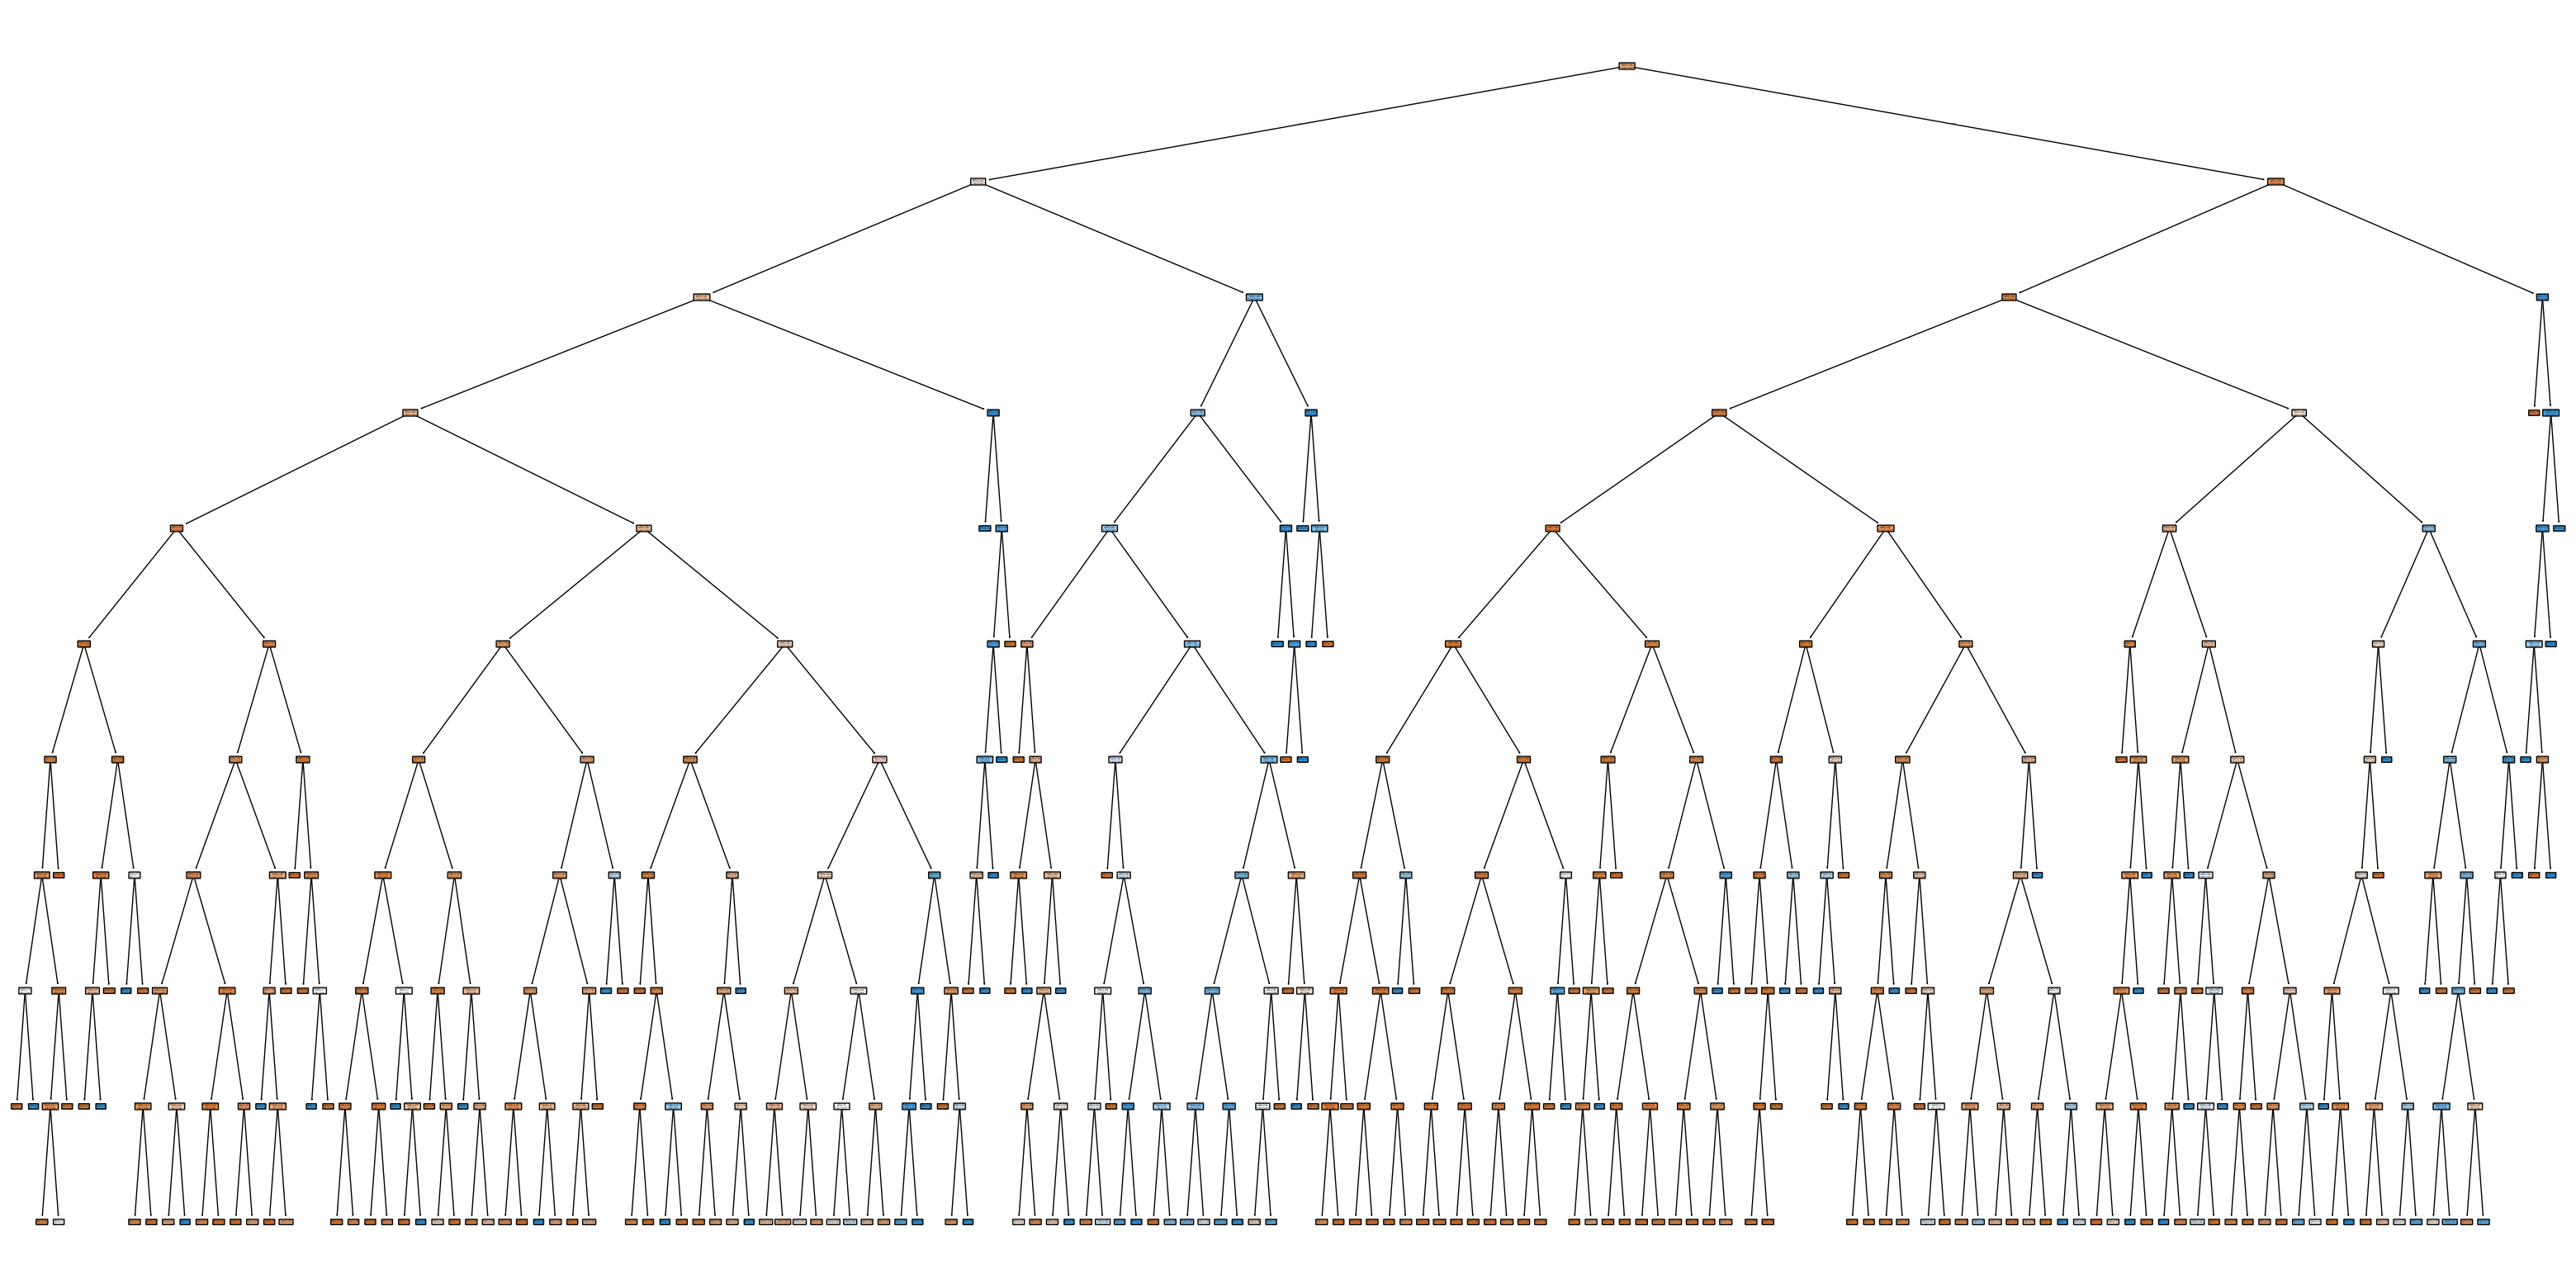

In [12]:
plt.figure(figsize=(40, 20))
tree.plot_tree(DTC, filled=True, feature_names = numericFeatures + categoricalFeatures, class_names=["<=50K", ">50K"], rounded=True)
plt.savefig("DTC.png", format="png", dpi=600) # You can zoom in and see the specifics of each node in the generated .png file
plt.show()

In [13]:
# ROC Curves

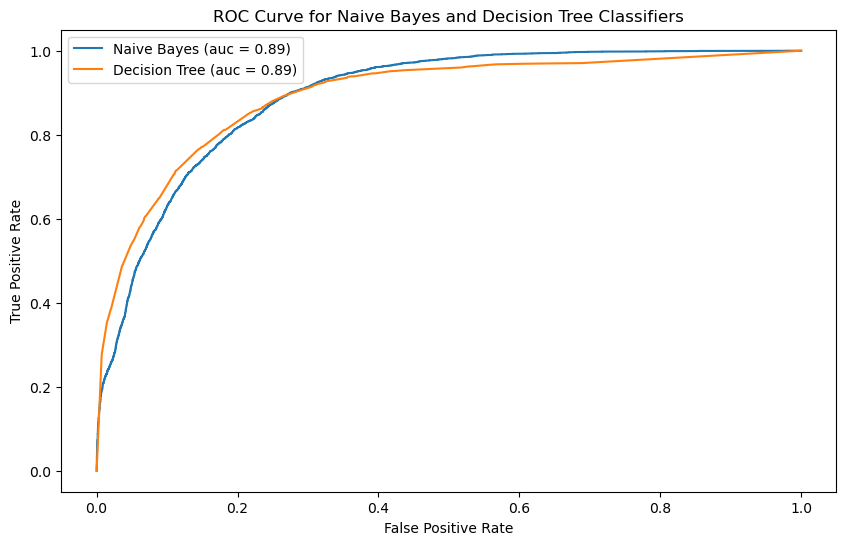

In [14]:
combinedProbabilityNB = CNB.predict_proba(categorical_test)[:, 1] * GNB.predict_proba(numeric_test)[:, 1]
fprNB, tprNB, _ = roc_curve(y_test, combinedProbabilityNB)
aucNB = roc_auc_score(y_test, combinedProbabilityNB)

probabilityDT = DTC.predict_proba(X_test)[:, 1]
fprDT, tprDT, _ = roc_curve(y_test, probabilityDT)
aucDT = roc_auc_score(y_test, probabilityDT)


plt.figure(figsize=(10, 6))
plt.plot(fprNB, tprNB, label='Naive Bayes (auc = %0.2f)' % aucNB)
plt.plot(fprDT, tprDT, label='Decision Tree (auc = %0.2f)' % aucDT)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Naive Bayes and Decision Tree Classifiers')
plt.legend(loc='best')
plt.show()